In [1]:
from datasets import load_dataset
import numpy as np
from collections import Counter
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

cache_dir = "./data_cache"

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  
    text = re.sub(r'\d+', '', text)  
    text = text.lower()  
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

def load_and_display_dataset(dataset_name, dataset_args=None, split_names=['train', 'validation', 'test']):
    if dataset_args is None:
        dataset_args = {}
    dataset = load_dataset(dataset_name, cache_dir=cache_dir, **dataset_args)
    for split_name in split_names:
        print(
            f"{split_name.capitalize()} Set Size:", len(dataset[split_name])
            )
        if split_name == 'train':
            sample_text = dataset['train'][0]['text']
            sample_label = dataset['train'][0]['label']
            print("\nSample Text:", sample_text)
            print("Sample Label:", sample_label)
            if dataset_name == "tweet_eval":
                train_labels = [sample['label'] for sample in dataset['train']]
                label_counts = Counter(train_labels)
                print("\nLabel Distribution in Training Set:", label_counts)
    return dataset  

dataset = load_and_display_dataset("tweet_eval", dataset_args={"name": "emotion"})

# extract the texts and labels from the dataset:
train_texts = [example['text'] for example in dataset['train']]
val_texts = [example['text'] for example in dataset['validation']]
test_texts = [example['text'] for example in dataset['test']]

train_labels = [example['label'] for example in dataset['train']]
val_labels = [example['label'] for example in dataset['validation']]
test_labels = [example['label'] for example in dataset['test']]

load_and_display_dataset("tweet_eval", dataset_args={"name": "emotion"})
texts = [
    "Here's an example: the quick brown fox jumps over the lazy dog.",
    "Another example: the quick red fox leaps over the tired dog."
]
processed_texts = [preprocess_text(text) for text in texts]


/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/leichen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leichen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Train Set Size: 3257

Sample Text: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
Sample Label: 2

Label Distribution in Training Set: Counter({0: 1400, 3: 855, 1: 708, 2: 294})
Validation Set Size: 374
Test Set Size: 1421
Train Set Size: 3257

Sample Text: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry
Sample Label: 2

Label Distribution in Training Set: Counter({0: 1400, 3: 855, 1: 708, 2: 294})
Validation Set Size: 374
Test Set Size: 1421


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
val_data = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

# model estabilish
model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, 100, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_data, train_labels, batch_size=128, epochs=10, validation_data=(val_data, val_labels))

print(model.evaluate(test_data, test_labels))


Epoch 1/10
26/26 [==============================] - 1s 28ms/step - loss: 1.3117 - accuracy: 0.4166 - val_loss: 1.2644 - val_accuracy: 0.4278
Epoch 2/10
26/26 [==============================] - 1s 24ms/step - loss: 1.2105 - accuracy: 0.4406 - val_loss: 1.2285 - val_accuracy: 0.4332
Epoch 3/10
26/26 [==============================] - 1s 24ms/step - loss: 1.0820 - accuracy: 0.5312 - val_loss: 1.1226 - val_accuracy: 0.5428
Epoch 4/10
26/26 [==============================] - 1s 24ms/step - loss: 0.7621 - accuracy: 0.7903 - val_loss: 0.9273 - val_accuracy: 0.6417
Epoch 5/10
26/26 [==============================] - 1s 24ms/step - loss: 0.4026 - accuracy: 0.8744 - val_loss: 0.8951 - val_accuracy: 0.6658
Epoch 6/10
26/26 [==============================] - 1s 27ms/step - loss: 0.2122 - accuracy: 0.9530 - val_loss: 0.9490 - val_accuracy: 0.6631
Epoch 7/10
26/26 [==============================] - 1s 26ms/step - loss: 0.1155 - accuracy: 0.9828 - val_loss: 1.0631 - val_accuracy: 0.6444
Epoch 8/10
26

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64, 5, activation='relu'))  
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))  
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))  # Dropout again
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_data, train_labels,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_data, val_labels),
                    callbacks=[early_stopping])


Epoch 1/10
26/26 [==============================] - 1s 20ms/step - loss: 1.3634 - accuracy: 0.3706 - val_loss: 1.3271 - val_accuracy: 0.4278
Epoch 2/10
26/26 [==============================] - 0s 18ms/step - loss: 1.3167 - accuracy: 0.4252 - val_loss: 1.3124 - val_accuracy: 0.4278
Epoch 3/10
26/26 [==============================] - 0s 17ms/step - loss: 1.2656 - accuracy: 0.4455 - val_loss: 1.2753 - val_accuracy: 0.4332
Epoch 4/10
26/26 [==============================] - 0s 17ms/step - loss: 1.1901 - accuracy: 0.4716 - val_loss: 1.2164 - val_accuracy: 0.4599
Epoch 5/10
26/26 [==============================] - 0s 17ms/step - loss: 1.0776 - accuracy: 0.5146 - val_loss: 1.1232 - val_accuracy: 0.5401
Epoch 6/10
26/26 [==============================] - 0s 18ms/step - loss: 0.9707 - accuracy: 0.5582 - val_loss: 1.0404 - val_accuracy: 0.5535
Epoch 7/10
26/26 [==============================] - 0s 18ms/step - loss: 0.8863 - accuracy: 0.6125 - val_loss: 1.0044 - val_accuracy: 0.5481
Epoch 8/10
26

In [4]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64, 3, activation='relu'))  # Use smaller core size
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))  # Adjust Dropout ratio
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.4))  
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_data, train_labels,
                    batch_size=64, 
                    epochs=10,
                    validation_data=(val_data, val_labels),
                    callbacks=[early_stopping])


Epoch 1/10
51/51 [==============================] - 1s 14ms/step - loss: 1.3311 - accuracy: 0.4080 - val_loss: 1.3010 - val_accuracy: 0.4278
Epoch 2/10
51/51 [==============================] - 1s 10ms/step - loss: 1.2630 - accuracy: 0.4228 - val_loss: 1.2641 - val_accuracy: 0.4278
Epoch 3/10
51/51 [==============================] - 1s 10ms/step - loss: 1.2091 - accuracy: 0.4372 - val_loss: 1.2167 - val_accuracy: 0.4332
Epoch 4/10
51/51 [==============================] - 1s 10ms/step - loss: 1.0758 - accuracy: 0.5081 - val_loss: 1.0972 - val_accuracy: 0.5615
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.9058 - accuracy: 0.6205 - val_loss: 0.9830 - val_accuracy: 0.6016
Epoch 6/10
51/51 [==============================] - 0s 10ms/step - loss: 0.7608 - accuracy: 0.6973 - val_loss: 0.9414 - val_accuracy: 0.6150
Epoch 7/10
51/51 [==============================] - 1s 11ms/step - loss: 0.6464 - accuracy: 0.7743 - val_loss: 0.9270 - val_accuracy: 0.6230
Epoch 8/10
51/

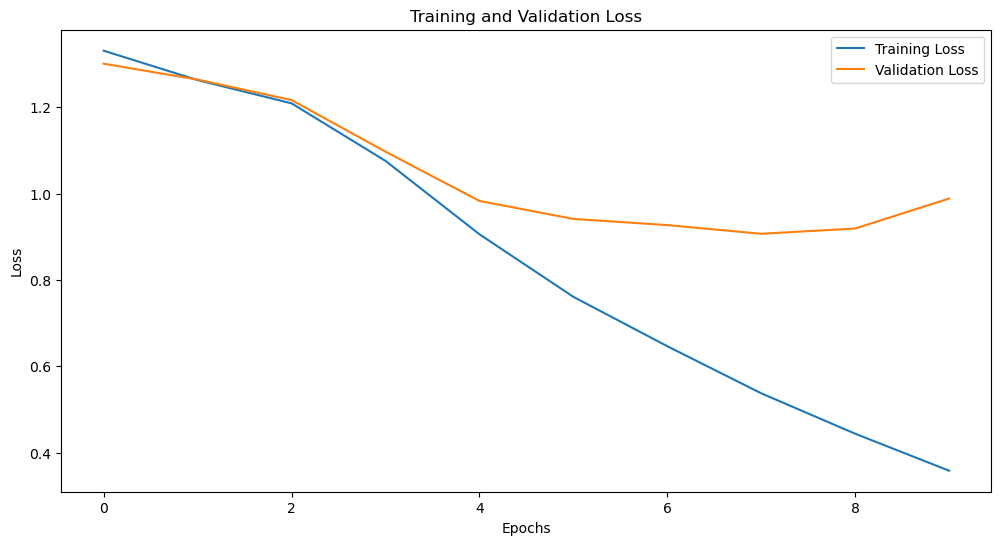

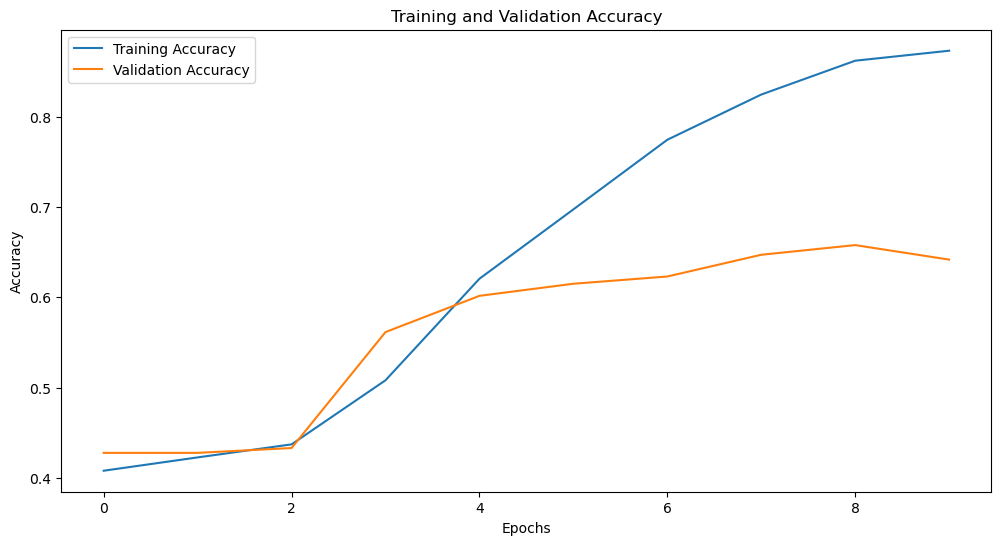

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy curves.
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/50
51/51 [==============================] - 1s 11ms/step - loss: 2.2634 - accuracy: 0.3930 - val_loss: 1.8447 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 2/50
12/51 [======>.......................] - ETA: 0s - loss: 1.8158 - accuracy: 0.4089

/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 1s 11ms/step - loss: 1.6593 - accuracy: 0.4292 - val_loss: 1.4939 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 1.4321 - accuracy: 0.4302 - val_loss: 1.3660 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 1.3392 - accuracy: 0.4295 - val_loss: 1.3052 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 1s 11ms/step - loss: 1.3007 - accuracy: 0.4298 - val_loss: 1.2811 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 1s 12ms/step - loss: 1.2714 - accuracy: 0.4295 - val_loss: 1.2559 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 1s 10ms/step - loss: 1.1785 - accuracy: 0.4467 - val_loss: 1.1851 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 8/50
51/51 [==============================] - 1s 10ms/step - loss: 1.0598 - accur

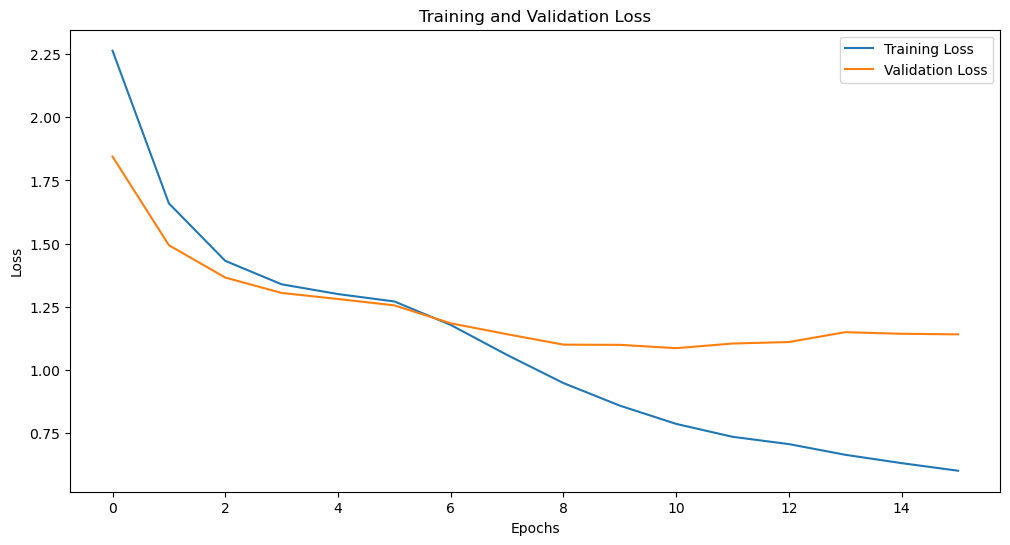

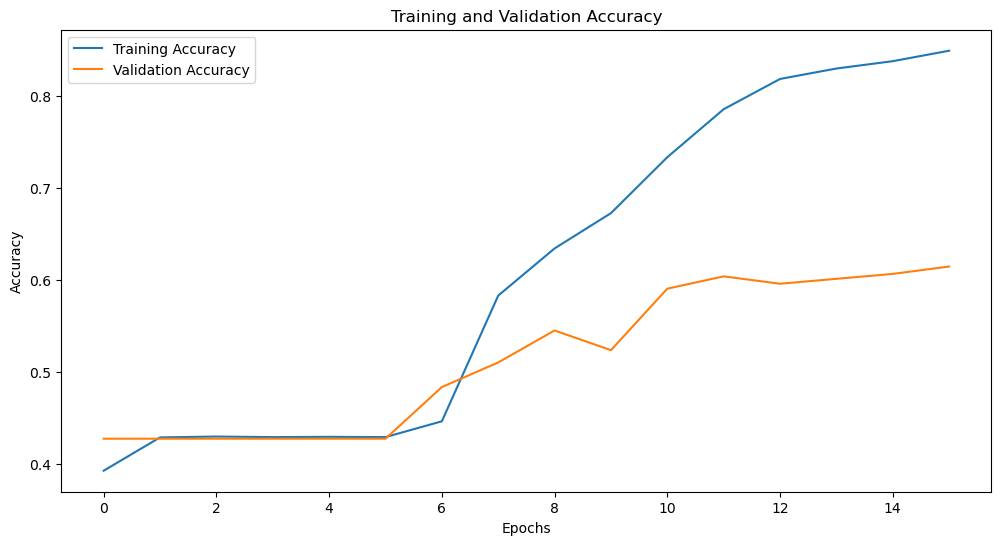

In [8]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2

MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6))  
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  
model.add(Dropout(0.6))  # Increase dropout ratio
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # add patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)  # Learning rate scheduler
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')  

history = model.fit(
    train_data, train_labels,
    batch_size=64,  
    epochs=50,  
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


45/45 [==============================] - 0s 2ms/step - loss: 1.1505 - accuracy: 0.5398
Test Loss: 1.1504889726638794
Test Accuracy: 0.5397607088088989
45/45 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       558
           1       0.00      0.00      0.00       358
           2       0.00      0.00      0.00       123
           3       0.41      0.78      0.53       382

    accuracy                           0.54      1421
   macro avg       0.27      0.41      0.32      1421
weighted avg       0.38      0.54      0.44      1421



/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/leichen/anaconda3/envs/tf_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

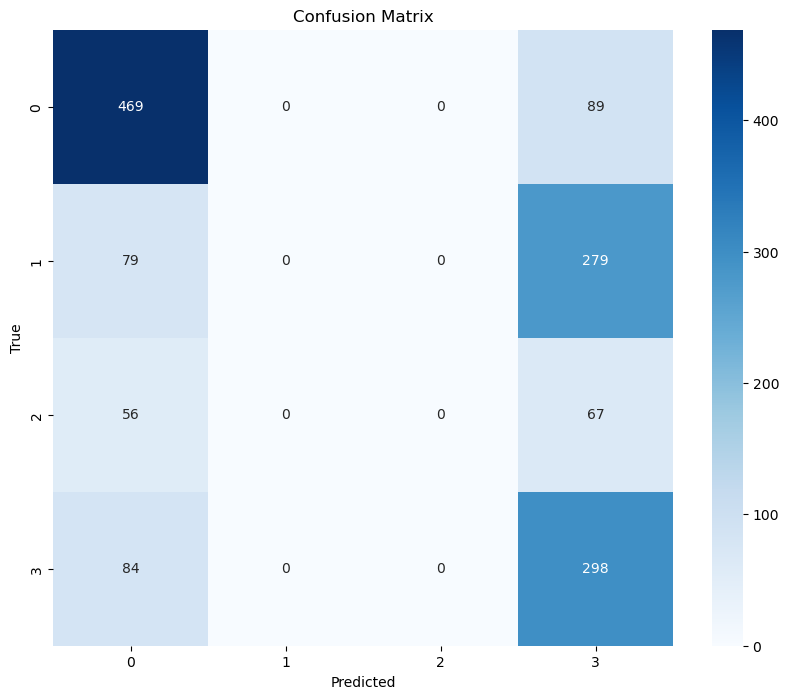

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
